## Interactive Node2Vec demo

Adapted from: https://github.com/pyg-team/pytorch_geometric/blob/master/examples/node2vec.py

(Read `./setup.md` for installation/setup instructions)

First let's import modules, define functions for training, testing, and plotting resulting `node2vec` embeddings, and load in our data (the Cora citation network):

In [1]:
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec

def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(
        train_z=z[data.train_mask],
        train_y=data.y[data.train_mask],
        test_z=z[data.test_mask],
        test_y=data.y[data.test_mask],
        max_iter=150,
    )
    return acc


@torch.no_grad()
def plot_points(colors, save=False):
    model.eval()
    z = model().cpu().numpy()
    z = TSNE(n_components=2).fit_transform(z)
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')

    if save:
        plt.savefig('node2vec.png')
    else:
        plt.show()

# Cora Citation Network Data: https://paperswithcode.com/dataset/cora
# nodes = publications, edges = citations
dataset = Planetoid('/project/macs40123/', name='Cora')
data = dataset[0]

Now, let's train the model:

In [2]:
# Train on GPU if available; takes <=1 min on GPU, ~15 min on CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize Node2Vec model with hyperparameters
model = Node2Vec(
    data.edge_index,
    embedding_dim=128,
    walk_length=20,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    p=1.0,
    q=1.0,
    sparse=True,
).to(device)

# define data loader (generates batches of rand walks) and optimizer
# for training Node2Vec model:
loader = model.loader(batch_size=128, shuffle=True)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

# Train for 100 epochs and print progress
for epoch in range(1, 101):
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Acc: {acc:.4f}')

Epoch: 001, Loss: 8.0252, Acc: 0.1700
Epoch: 002, Loss: 6.0545, Acc: 0.1880
Epoch: 003, Loss: 4.9440, Acc: 0.2160
Epoch: 004, Loss: 4.1265, Acc: 0.2500
Epoch: 005, Loss: 3.4565, Acc: 0.2820
Epoch: 006, Loss: 2.9519, Acc: 0.3070
Epoch: 007, Loss: 2.5387, Acc: 0.3400
Epoch: 008, Loss: 2.2041, Acc: 0.3730
Epoch: 009, Loss: 1.9454, Acc: 0.4040
Epoch: 010, Loss: 1.7366, Acc: 0.4250
Epoch: 011, Loss: 1.5568, Acc: 0.4520
Epoch: 012, Loss: 1.4225, Acc: 0.4840
Epoch: 013, Loss: 1.3137, Acc: 0.5100
Epoch: 014, Loss: 1.2252, Acc: 0.5240
Epoch: 015, Loss: 1.1518, Acc: 0.5440
Epoch: 016, Loss: 1.1030, Acc: 0.5800
Epoch: 017, Loss: 1.0557, Acc: 0.5950
Epoch: 018, Loss: 1.0202, Acc: 0.6130
Epoch: 019, Loss: 0.9914, Acc: 0.6210
Epoch: 020, Loss: 0.9667, Acc: 0.6330
Epoch: 021, Loss: 0.9479, Acc: 0.6420
Epoch: 022, Loss: 0.9322, Acc: 0.6520
Epoch: 023, Loss: 0.9204, Acc: 0.6480
Epoch: 024, Loss: 0.9100, Acc: 0.6620
Epoch: 025, Loss: 0.8992, Acc: 0.6660
Epoch: 026, Loss: 0.8928, Acc: 0.6700
Epoch: 027, 

Finally, let's reduce our embeddings down to 2 dimensions and plot them in different colors based on the class of academic publication/node they belong to. Did `node2vec` learn to distinguish the node classes based on the network structure?

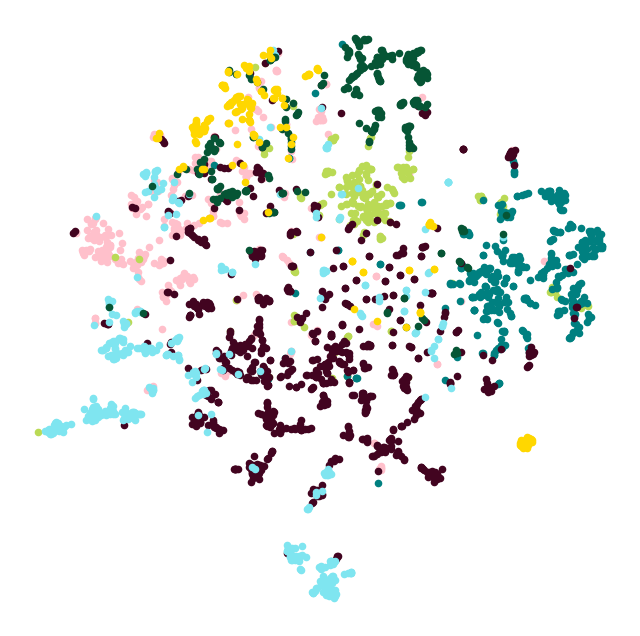

In [3]:
colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700'
]
plot_points(colors)